<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# 1. Problem description and objective:

## a. Motivation:

Ads industry heavily relies on data science to determine, 

1. which ad to show, 
2. how much to spend, 
3. ways to optimize the ad text, 
4. position of the ad and etc. 

Many companies spend millions of dollars on ads however they spend little to none on data science targeting ad optimizations. Investing more time and resource on data science will definitely yield better performance from ads and increased revenue to the company. (Major companies who invest a lot on Data science for Ad campaign - Google and Facebook)

Most of the companies have huge amount of unused data from advertisements (TBs to PBs). It is imperative, for the benefit of the company, to apply data mining and machine learning techniques for better use of the data by extracting useful information and developing predictive models.

## b. Description:

XYZ - a food delivery company. It relies on online ads to get customers such as those we see on Google or Facebook.

Currently running 40 different ad campaigns and they want to understand the performance and improve them.

<b>Parameters:</b>

<b>date :</b> All data are aggregated by date <br>

<b>shown :</b> Number of ads shown on a given day all over the web. Impressions are free. That is, companies pay only if a user clicks on the ad, not to show it <br>

<b>clicked :</b> Number of clicks on the ads. This is what companies pay for. By clicking on
the ad, the user is brought to the site <br>

<b>converted :</b> Number of conversions on the site coming from ads. To be counted, a conversion has to happen on the same day as the ad click.<br>

<b>avg_cost_per_click :</b> On an average, how much it cost each of those clicks <br>

<b>total_revenue :</b> How much revenue came from the conversions <br>

<b>ad :</b> We have several different ad groups. This shows which ad group we are considering

## c. Objective of the project:

Understand the performance of 40 ad campaigns:
1. Identify 5 best ad groups. Justify the metric chosen. Explain the pros and cons of the metric.
2. For each group predict how many ads will be shown on a particular date (let's say Dec 15). Assume that each group follows its trend.
3. Cluster ads into 3 groups:<br>
    a. avg_cost_per_click is going up<br>
    b. avg_cost_per_click is constant<br>
    c. avg_cost_per_click is going down



# 2. Data Exploration:

In [18]:
% matplotlib inline

import pandas as pd
import math as m
from bdateutil import isbday
import holidays
from datetime import date
import seaborn as sns

In [2]:
folder1 = "C:/Users/venki_k07/Google Drive/Data science - Datasets/Ads_analysis/"
folder2 = "C:/Users/Venkatesh/Google Drive/Data science - Datasets/Ads_analysis/"

In [13]:
df = pd.read_csv( folder1 + "ad_table.csv" )

In [14]:
df.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


Dimension of the dataframe:

In [16]:
df.shape

(2115, 7)

Unique ad groups in the dataset

In [29]:
df['ad'].unique()

array(['ad_group_1', 'ad_group_2', 'ad_group_3', 'ad_group_4',
       'ad_group_5', 'ad_group_6', 'ad_group_7', 'ad_group_8',
       'ad_group_9', 'ad_group_10', 'ad_group_11', 'ad_group_12',
       'ad_group_13', 'ad_group_14', 'ad_group_15', 'ad_group_16',
       'ad_group_17', 'ad_group_18', 'ad_group_19', 'ad_group_20',
       'ad_group_21', 'ad_group_22', 'ad_group_23', 'ad_group_24',
       'ad_group_25', 'ad_group_26', 'ad_group_27', 'ad_group_28',
       'ad_group_29', 'ad_group_30', 'ad_group_31', 'ad_group_32',
       'ad_group_33', 'ad_group_34', 'ad_group_35', 'ad_group_36',
       'ad_group_37', 'ad_group_38', 'ad_group_39', 'ad_group_40'], dtype=object)

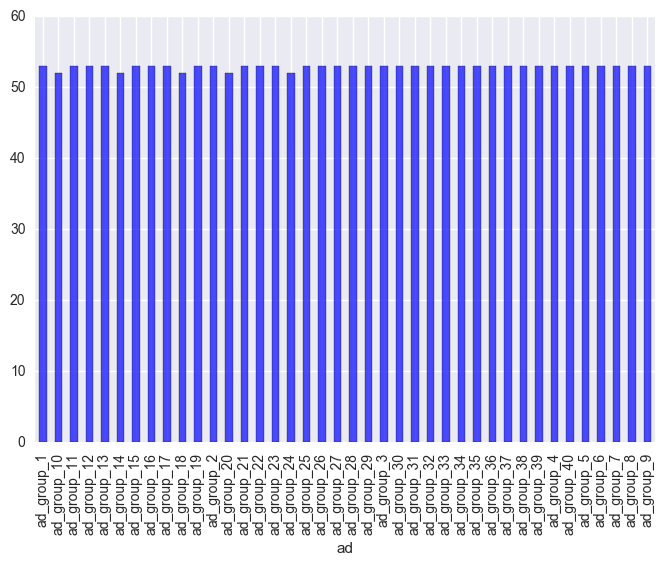

In [24]:
dff = df.groupby('ad')['shown'].count()
dff.plot.bar(color = 'b', alpha=0.7)

The bar chart clearly shows us that we have almost equal number of data points for each group. So we could direct apply random sampling technique (Monte Carlo) to select data for modeling and validation. 

In case, the data is not uniformly distributed among the different groups, then we should apply stratified sampling technique to pick a sample data that represents the actual population.

The above contruct is applicable only when we have similar dependancies between variables in each group such that the group category can be ignored in modeling. 

Let's check the above using simple scatter plot between different variables.

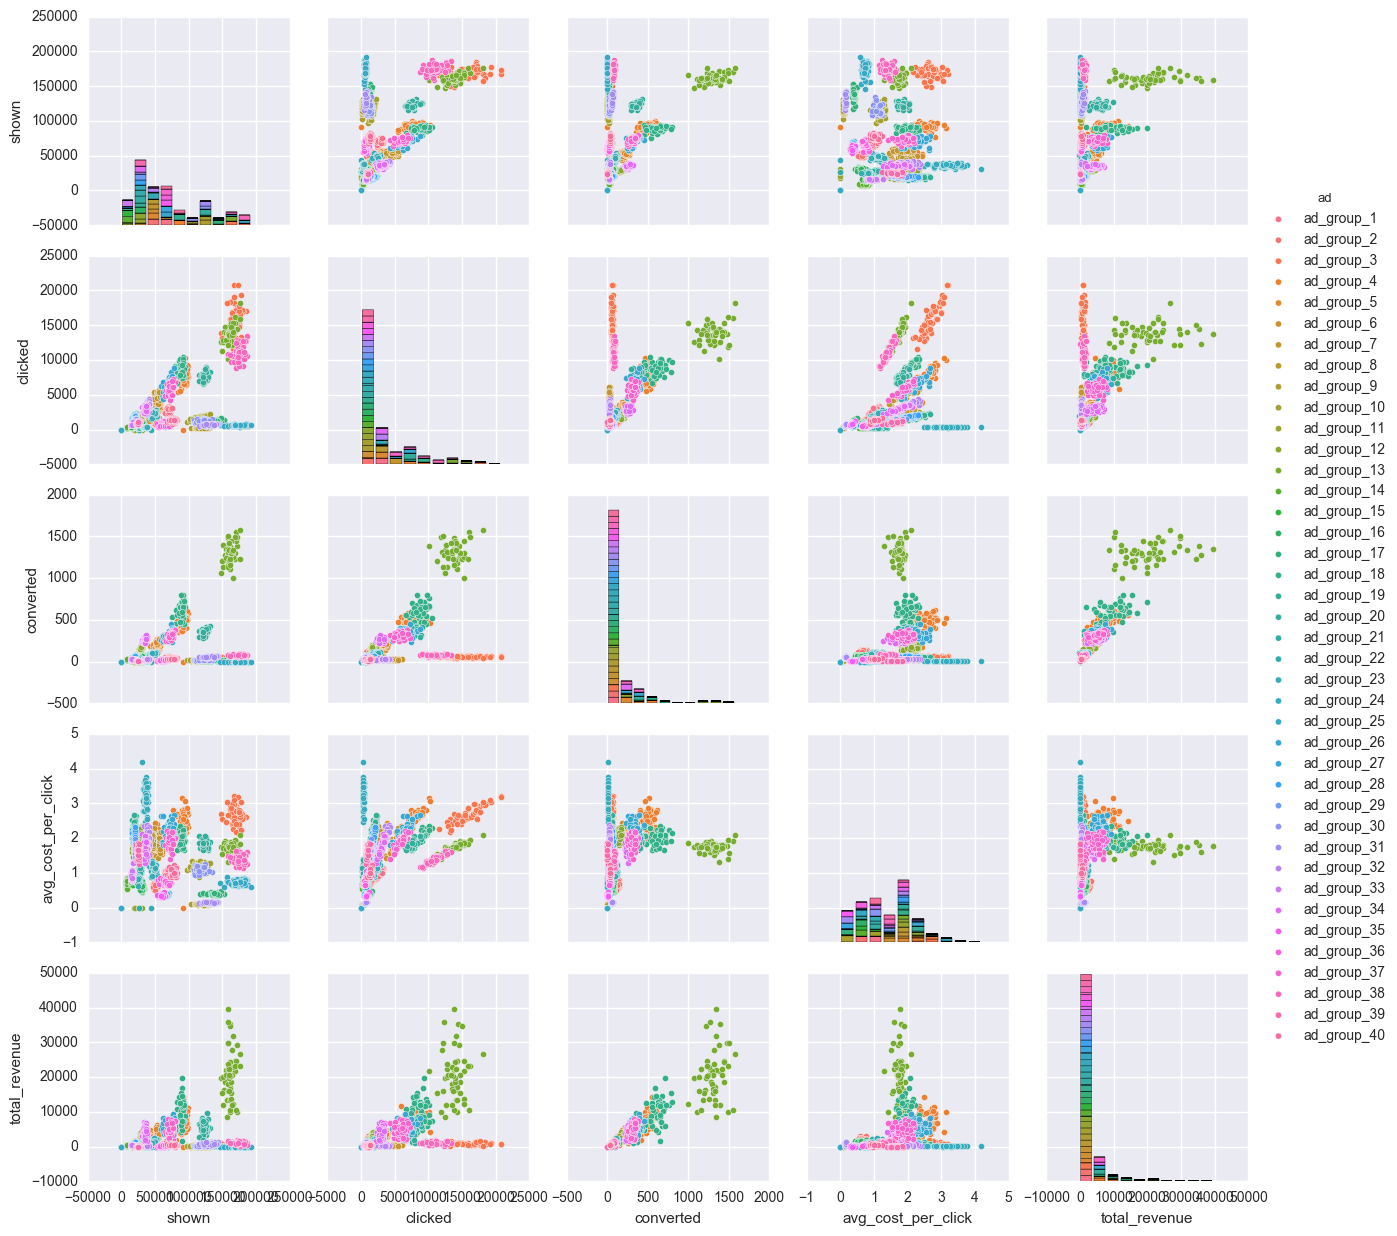

In [33]:
sns.pairplot(df[['shown', 'clicked', 'converted', 'avg_cost_per_click', 'total_revenue', 'ad']], hue = 'ad')

The above pairplot shows no clear correlation between any of the variables in the table when we use data from all the groups combined. However, the plot shows clusters of data that might have linear and non-linear relationships between corresponding parameters. As we have multiple clusters in each of the above plots, when we group the data based on ad_group we might discover useful relationship between the parameters.

<b> Considering ad group 1: </b>

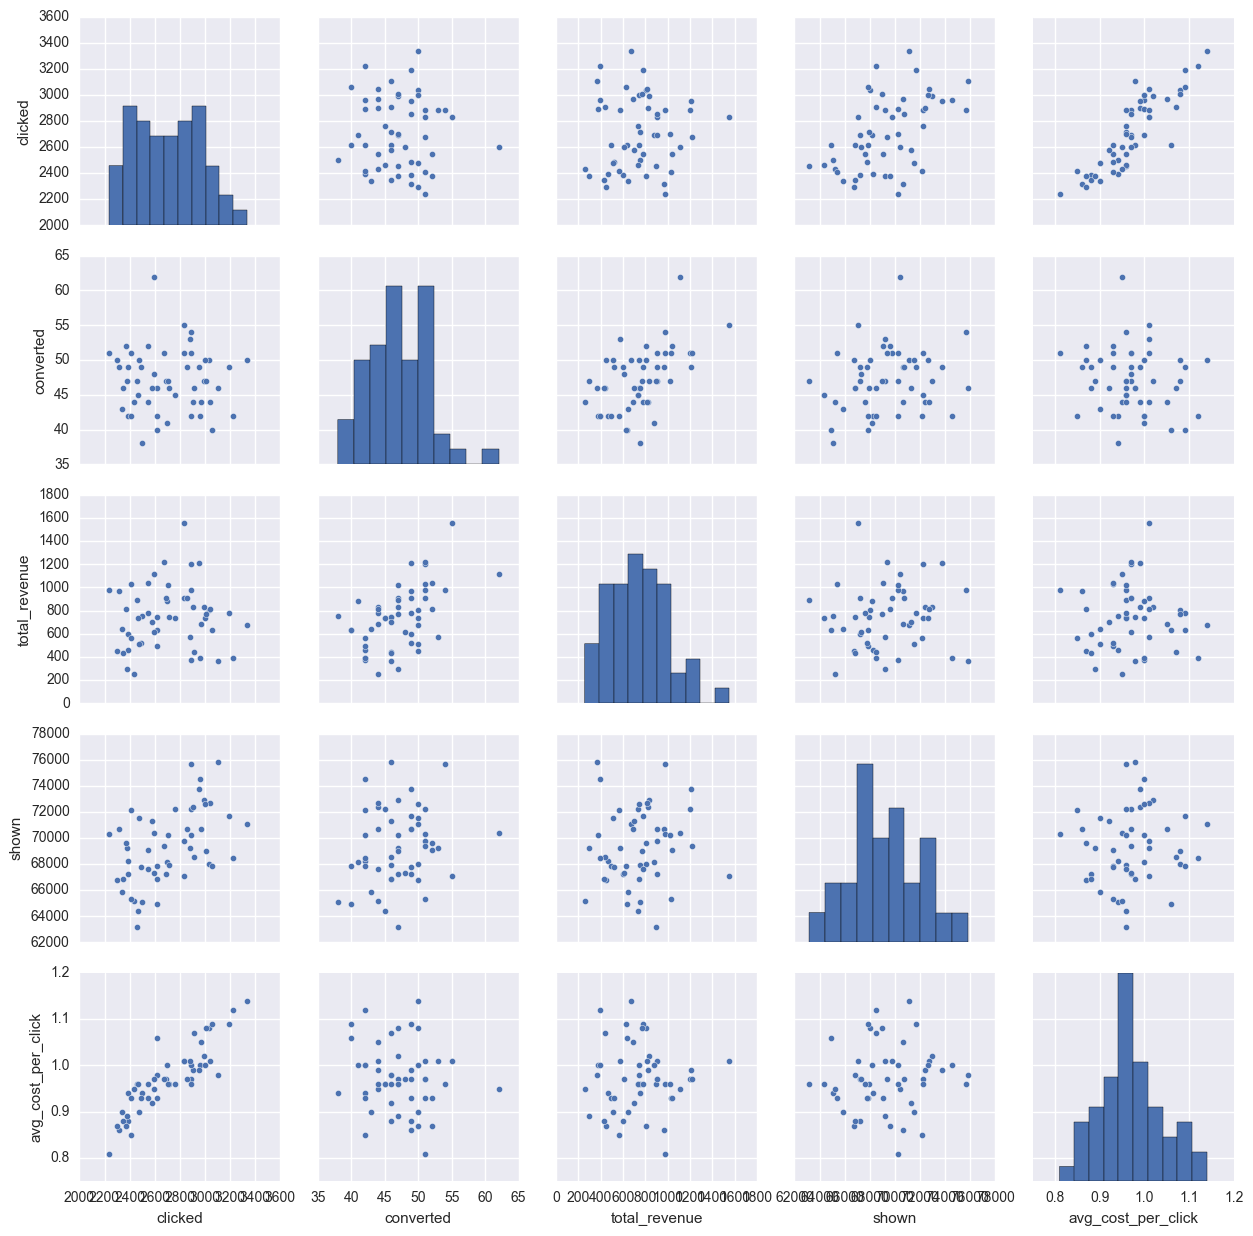

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_1', {'shown', 'clicked', 'converted', 'avg_cost_per_click', 'total_revenue'}])

In [5]:
df['clicked_rate'] = df['clicked'] / df['shown']
df['conversion_rate'] = df['converted'] / df['clicked']

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
US_holidays = holidays.US()
df['Wday'] = [isbday(x, US_holidays) for x in df['date']]

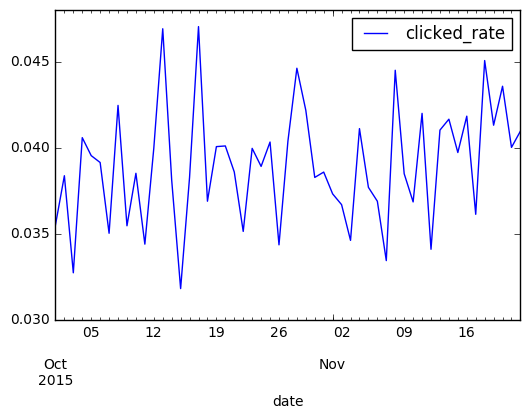

In [22]:
df.ix[df.ad == 'ad_group_1'].plot('date', 'clicked_rate')

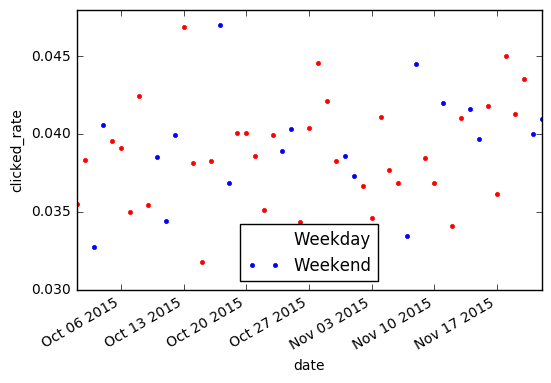

In [24]:
ax1 = df.ix[(df.ad == 'ad_group_1') & (df.Wday == 1)].plot.line(x = 'date', y = 'clicked_rate', style = '.', color = 'red', label = 'Weekday')
df.ix[(df.ad == 'ad_group_1') & (df.Wday == 0)].plot.line(x = 'date', y = 'clicked_rate', style = '.', ax = ax1, color = 'blue', label = 'Weekend')
ax1.set_ylabel('clicked_rate')

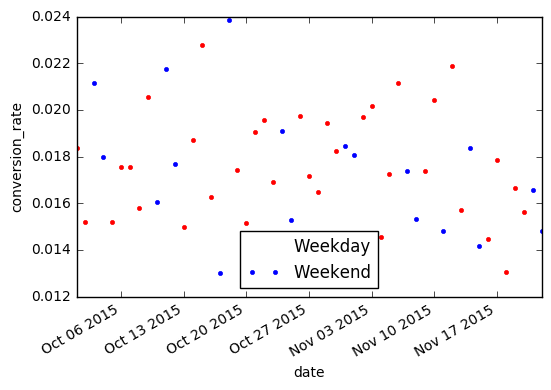

In [25]:
ax1 = df.ix[(df.ad == 'ad_group_1') & (df.Wday == 1)].plot.line(x = 'date', y = 'conversion_rate', style = '.', color = 'red', label = 'Weekday')
df.ix[(df.ad == 'ad_group_1') & (df.Wday == 0)].plot.line(x = 'date', y = 'conversion_rate', style = '.', ax = ax1, color = 'blue', label = 'Weekend')
ax1.set_ylabel('conversion_rate')

### A/B testing:

Applying A/B testing to determine whether the clicked_rate during weekend is statistiscally different from weekday or not

In [27]:
df.ix[(df.ad == 'ad_group_1') & (df.Wday == 1), 'clicked_rate'].describe()

count    35.000000
mean      0.038847
std       0.003424
min       0.031818
25%       0.036412
50%       0.038487
75%       0.041064
max       0.046905
Name: clicked_rate, dtype: float64

In [33]:
print("Skewness:", df.ix[(df.ad == 'ad_group_1') & (df.Wday == 1), 'clicked_rate'].skew())
print("Kurtosis:", df.ix[(df.ad == 'ad_group_1') & (df.Wday == 1), 'clicked_rate'].kurtosis())

Skewness: 0.283738378732
Kurtosis: -0.167111482595


In [28]:
df.ix[(df.ad == 'ad_group_1') & (df.Wday == 0), 'clicked_rate'].describe()

count    18.000000
mean      0.039308
std       0.003586
min       0.032735
25%       0.037616
50%       0.039843
75%       0.040866
max       0.047029
Name: clicked_rate, dtype: float64

<b>Hypothesis:</b><br>
    <tab>Null hypothesis        H0: No difference in clicked_rates <br>
    <tab>Alternative hypothesis H1: Statistically significant difference between clicked_rates <br>
    
Assumed p = 0.05 and power = 0.2

In [34]:
clicked_weekday = df.ix[(df.ad == 'ad_group_1') & (df.Wday == 1), 'clicked_rate']
clicked_weekend = df.ix[(df.ad == 'ad_group_1') & (df.Wday == 0), 'clicked_rate']

Parameters required for calculating p-value and 1-power:
    <br>p-value: probability of not rejecting the null-hypothesis ( > 0.05 )</br>
    <br>Power (1-tolerance): Probability of not accepting the alternative hypothesis ( > 0.8 )</br>